## ExMaas & MaaSSim - Pricing Model

## Steps:
    1. Load Nootdord: Network 
    2. Set Demand: 2 travellers and 1 Vehicles
    3. Run ExMaas: Make sure there is a pooling  (inDataSlbts)
    4. Run MaaSSim
    5. Choice set for drivers  - use sblts.rides in prep_shared_rides and not sblts.schedule
    6. Decision 

## Adding paths

In [61]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize the MaaSSim

In [62]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
import logging

## Initialize the ExMAS

In [63]:
import pandas as pd
import ExMAS

## Load the Graph

In [64]:
params = get_config('D:/Development/MaaSSim/data/config/Nootdorp.json')  # load configuration

## Set Demand

In [65]:
params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 4 # 1 hour of simulation
params.nP = 10  # uqests (and passengers)
params.nV = 2  # hicles

In [66]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True

In [67]:
inData = load_G(inData, params)  # load network graph 

In [68]:
inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

## create shareability graph (ExMAS) 

In [69]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

26-10-22 11:57:32-INFO-Initializing pairwise trip shareability between 10 and 10 trips.
26-10-22 11:57:32-INFO-creating combinations
26-10-22 11:57:32-INFO-90	 nR*(nR-1)
26-10-22 11:57:32-INFO-Reduction of feasible pairs by 100.00%
26-10-22 11:57:32-INFO-Degree 2 	Completed
26-10-22 11:57:32-INFO-trips to extend at degree 2 : 1
26-10-22 11:57:32-INFO-At degree 2 feasible extensions found out of 0 searched
26-10-22 11:57:32-INFO-Degree 3 	Completed
26-10-22 11:57:32-INFO-No more trips to exted at degree 3


## Analyze results

In [85]:
inData.sblts.schedule.indexes

0        [0]
1        [1]
4        [4]
5        [5]
6        [6]
7        [7]
8        [8]
9        [9]
10    [2, 3]
Name: indexes, dtype: object

In [70]:
Results = inData.sblts.rides

In [71]:
Results

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index
0,[0],6.54100,353,1,[6.541],"[0, 353]",[0],[0],1.0,0
1,[1],2.17650,117,1,[2.1765],"[709, 117]",[1],[1],1.0,1
2,[2],3.50250,189,1,[3.5025000000000004],"[1610, 189]",[2],[2],1.0,2
3,[3],3.63500,196,1,[3.635],"[1795, 196]",[3],[3],1.0,3
4,[4],0.76000,41,1,[0.76],"[3186, 41]",[4],[4],1.0,4
5,[5],0.87400,47,1,[0.874],"[7944, 47]",[5],[5],1.0,5
6,[6],1.03100,55,1,[1.0310000000000001],"[9576, 55]",[6],[6],1.0,6
7,[7],1.68500,91,1,[1.685],"[10057, 91]",[7],[7],1.0,7
8,[8],3.27750,177,1,[3.2775],"[11388, 177]",[8],[8],1.0,8
9,[9],4.17600,225,1,[4.176],"[12747, 225]",[9],[9],1.0,9


In [72]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

26-10-22 11:57:51-INFO-Matching 10 trips to 11 rides in order to min u_pax
26-10-22 11:57:51-INFO-Problem solution: Optimal. 
Total costs for single trips:             27 
reduced by matching to:                   27
26-10-22 11:57:52-WARNING-Setting up 4h simulation at 2022-10-26 10:07:39 for 2 vehicles and 10 passengers in Nootdrop, Netherlands
26-10-22 11:57:52-WARNING-simulation time 0.1 s
26-10-22 11:57:52-WARNING-assertion tests for simulation results - passed


In [73]:
sim.runs[0].rides

,veh,pos,t,event,paxes
0,1,838048032.0,0,STARTS_DAY,[]
1,1,838048032.0,0,OPENS_APP,[]
2,1,838048032.0,0,RECEIVES_REQUEST,[]
3,1,838048032.0,15,ACCEPTS_REQUEST,[]
4,1,838048032.0,35,IS_ACCEPTED_BY_TRAVELLER,[]
...,...,...,...,...,...
58,2,44997882.0,12821,ARRIVES_AT_PICKUP,[]
59,2,44997882.0,12821,MEETS_TRAVELLER_AT_PICKUP,[]
60,2,44997882.0,12851,DEPARTS_FROM_PICKUP,[9]
61,2,45031258.0,13076,ARRIVES_AT_DROPOFF,[9]


In [74]:
sim.runs[0].trips

,pax,pos,t,event,veh_id
0,0,2014445729,0,STARTS_DAY,NaN
1,0,2014445729,0,REQUESTS_RIDE,NaN
2,0,2014445729,0,RECEIVES_OFFER,NaN
3,0,2014445729,15,ACCEPTS_OFFER,NaN
4,0,2014445729,35,ARRIVES_AT_PICKUP,1.0
...,...,...,...,...,...
5,9,44997882,12821,MEETS_DRIVER_AT_PICKUP,2.0
6,9,44997882,12851,DEPARTS_FROM_PICKUP,2.0
7,9,45031258,13076,ARRIVES_AT_DROPOFF,2.0
8,9,45031258,13086,SETS_OFF_FOR_DEST,NaN


<AxesSubplot:>

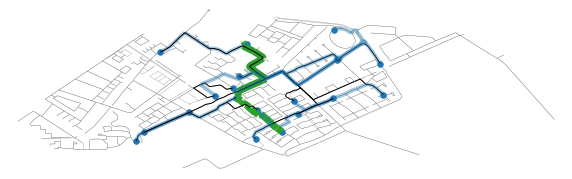

In [75]:
df = sim.runs[0].rides

for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==2], lw = 1)

In [76]:
sim.requests

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,dist,platform,ride_id,position,sim_schedule
id,,,,,,,,,,,,,,,
1,0,2014445729,2273226090,2022-10-26 10:07:39,NaN,0 days 00:58:57,2022-10-26 11:06:36,NaN,True,NaN,3537,0,0,0,node time req_id od 0 ...
2,1,519520441,5040974840,2022-10-26 10:19:28,NaN,0 days 00:19:38,2022-10-26 10:39:06,NaN,True,NaN,1178,0,1,0,node time req_id od 0 ...
3,2,5257342095,45024107,2022-10-26 10:34:29,NaN,0 days 00:31:34,2022-10-26 11:06:03,NaN,True,NaN,1894,0,10,0,node time req_id od 0 ...
4,4,44994287,500965113,2022-10-26 11:00:45,NaN,0 days 00:06:51,2022-10-26 11:07:36,NaN,True,NaN,411,0,4,0,node time req_id od 0 N...
5,5,44974254,44989725,2022-10-26 12:20:03,NaN,0 days 00:07:53,2022-10-26 12:27:56,NaN,True,NaN,473,0,5,0,node time req_id od 0 NaN...
6,6,515765264,44988793,2022-10-26 12:47:15,NaN,0 days 00:09:19,2022-10-26 12:56:34,NaN,True,NaN,559,0,6,0,node time req_id od 0 N...
7,7,44996094,1402824226,2022-10-26 12:55:16,NaN,0 days 00:15:11,2022-10-26 13:10:27,NaN,True,NaN,911,0,7,0,node time req_id od 0 ...
8,8,1619407431,45001243,2022-10-26 13:17:27,NaN,0 days 00:29:32,2022-10-26 13:46:59,NaN,True,NaN,1772,0,8,0,node time req_id od 0 ...
9,9,44997882,45031258,2022-10-26 13:40:06,NaN,0 days 00:37:39,2022-10-26 14:17:45,NaN,True,NaN,2259,0,9,0,node time req_id od 0 NaN...


## TrevelAgent

In [77]:
self = sim.pax[0]

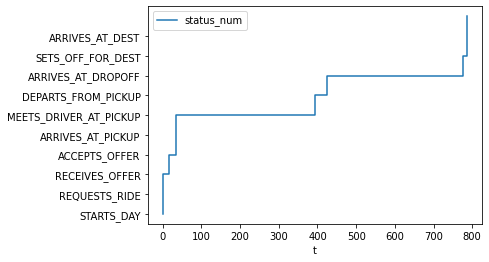

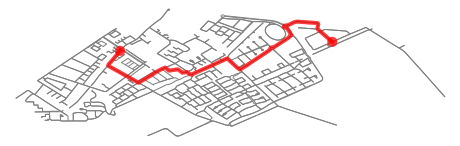

<AxesSubplot:xlabel='t'>

In [78]:
from MaaSSim.visualizations import plot_trip
plot_trip(sim, self.id)

## VehicleAgent

In [82]:
self = sim.vehs[2]

<AxesSubplot:>

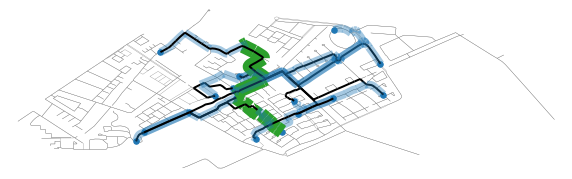

In [83]:
from MaaSSim.visualizations import plot_veh_sim
plot_veh_sim(sim, self.id)